# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
# Импортируем неоьходиые библиотеки
from tensorflow import keras
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


from PIL import Image
import pathlib
import os

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
path = r"datasets/"
path_image_train = r"datasets/train_images"
path_image_test = r"datasets/test_images"

In [3]:
train = pd.read_csv(path + 'train_dataset.csv')

In [4]:
display(train.describe())
train.info()

image                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [5]:
expert_annotations = pd.read_csv(path + 'ExpertAnnotations.tsv',
                                 sep="\t",
                                 names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])

In [6]:
display(expert_annotations.describe())
display(expert_annotations.info())
expert_annotations.head(10)

expert_1     expert_2     expert_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2         1         1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2         1         1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2         1         1   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2         1         1   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2         2         2   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2  
5         1  
6         1  
7         2  
8         1  
9         2

<AxesSubplot:ylabel='Frequency'>

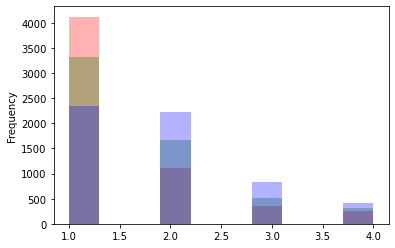

In [7]:
expert_annotations['expert_1'].plot(kind='hist', color='r', alpha=0.3)
expert_annotations['expert_2'].plot(kind='hist', color='g', alpha=0.3)
expert_annotations['expert_3'].plot(kind='hist', color='b', alpha=0.3)

Как можно заметить оценки эксперт отличаются, причем самым строгим является первый эксперт, большая часть картинок для него не соответсвует описания, второй эксперт чуть менее категоричен, а 3 самый лояльный из всех трех

Отбор изображений будет вестись по методу голосования большинства так, что будут отобраны те изображения и описания к ним при которых мнение хотя бы двух экспертов совпало

In [8]:
def cumulate_score(row):
    if row['expert_1'] == row['expert_2'] or row['expert_1'] == row['expert_3']:
        row['expert_score'] = row['expert_1']
    elif row['expert_2'] == row['expert_3']:
        row['expert_score'] = row['expert_2']
    return row

In [9]:
expert_annotations = expert_annotations.apply(lambda row: cumulate_score(row), axis=1)

избавимся от строк в которых оценка не была поставлена

In [10]:
expert_annotations = expert_annotations.dropna()
expert_annotations['expert_score'] = expert_annotations['expert_score'].astype('int64')
display(expert_annotations.info())
expert_annotations.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5696 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   expert_1      5696 non-null   int64 
 1   expert_2      5696 non-null   int64 
 2   expert_3      5696 non-null   int64 
 3   expert_score  5696 non-null   int64 
 4   image         5696 non-null   object
 5   query_id      5696 non-null   object
dtypes: int64(4), object(2)
memory usage: 311.5+ KB


None

expert_1  expert_2  expert_3  expert_score                      image  \
0         1         1         1             1  1056338697_4f7d7ce270.jpg   
1         1         1         2             1  1056338697_4f7d7ce270.jpg   

                      query_id  
0  2549968784_39bfbe44f9.jpg#2  
1  2718495608_d8533e3ac5.jpg#2

Далее будет произведена агрегация оценок после краудсорсинга, соответствие и нессответствие изображений предлагается также привести к 4 бальной системе оценивания, как это осуществлено у экспертов. Метод преобразования следующий:
* 1 - Оценка, которая будет выставлена в случае если доля людей подтвердивших соответствие описания и картинки составляет менее 25 процентов
* 2 - если та же оценка лежит в пределах 25 и 50 процентов
* 3 - оценка в пределах 50 и 75 процентов
* 4 - оценка в пределах 75 и 100 процентов

In [11]:
crowd_annotations = pd.read_csv(path + 'CrowdAnnotations.tsv',
                                 sep="\t",
                                 names=['image', 'query_id', 'fraction', 'number_yes', 'number_no'])

In [12]:
display(crowd_annotations.describe())
display(crowd_annotations.info())
crowd_annotations.head(3)

fraction    number_yes     number_no
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       47830 non-null  object 
 1   query_id    47830 non-null  object 
 2   fraction    47830 non-null  float64
 3   number_yes  47830 non-null  int64  
 4   number_no   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

image                     query_id  fraction  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2       1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2       0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2       0.0   

   number_yes  number_no  
0           3          0  
1           0          3  
2           0          3

<AxesSubplot:ylabel='Frequency'>

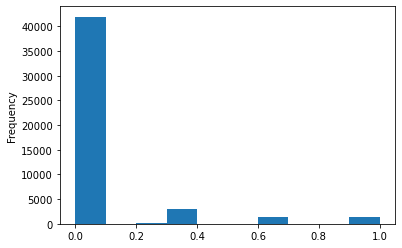

In [13]:
crowd_annotations['fraction'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

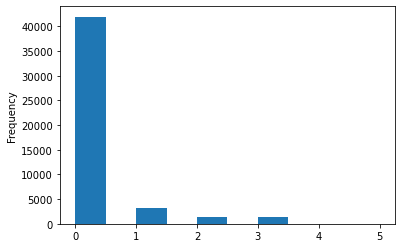

In [14]:
crowd_annotations['number_yes'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

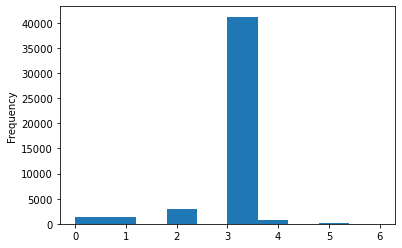

In [15]:
crowd_annotations['number_no'].plot(kind='hist')

Исходя из графиков можно заметить, что краудсорсинг гораздо реже, чем эксперты помечает что избражение и текст действительно совпали, поэтому при получении финальных оценок совмещенных краудсорсинга и экспертов их оценки будут учтены с вероятностью меньшей чем у экспертов а именно 0.3

In [16]:
def fraction_score(row):
    if row['fraction'] < 0.25:
        row['crowd_score'] = 1
    elif 0.25 <= row['fraction'] < 0.5:
        row['crowd_score'] = 2
    elif 0.5 <= row['fraction'] < 0.75:
        row['crowd_score'] = 3
    elif 0.75 <= row['fraction'] <= 1.:
        row['crowd_score'] = 4
    return row

In [17]:
crowd_annotations = crowd_annotations.apply(lambda row: fraction_score(row), axis=1)
crowd_annotations.head(5)

image                     query_id  fraction  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2       1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2       0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2       0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2       0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2       0.0   

   number_yes  number_no  crowd_score  
0           3          0            4  
1           0          3            1  
2           0          3            1  
3           0          3            1  
4           0          3            1

Далее проведем совмещение оценок экспертов и краудсорсинга где голос эксперта будет учтен с коэффициентом 0.7, а крауда 0.3, иными словами если для описания к одной картинке финальная оценка эксперта составила 3, а крауда 1, совмещенной оценкой будет результат выражения 3 * 0.7 + 1 * 0.3, а именоо 2.4, после чего все оценки будет шкалировать и привести к диапазону от 0 до 1 с помощью MinMaxScaler, для успешного дальнейшего обучения модели 

In [18]:
expert_annotations['expert_score'] = expert_annotations['expert_score'] * 0.7
crowd_annotations['crowd_score'] = crowd_annotations['crowd_score'] * 0.3

In [19]:
df = pd.merge(expert_annotations, crowd_annotations, on=['image', 'query_id'])

In [20]:
scaler = MinMaxScaler()
df['score'] = df['crowd_score'] * df['expert_score']
df['score'] = scaler.fit_transform(df[['score']])

Избавимся от лишних столбцов и оставим только колонку с изображение описанием и финальной оценкой

In [21]:
df = df[['query_id', 'image', 'score']]
df.head()

query_id                      image     score
0  2549968784_39bfbe44f9.jpg#2  1056338697_4f7d7ce270.jpg  0.000000
1  2718495608_d8533e3ac5.jpg#2  1056338697_4f7d7ce270.jpg  0.000000
2   434792818_56375e203f.jpg#2  1056338697_4f7d7ce270.jpg  0.000000
3   256085101_2c2617c5d0.jpg#2  1084040636_97d9633581.jpg  0.333333
4  3396157719_6807d52a81.jpg#2  1084040636_97d9633581.jpg  0.066667

<AxesSubplot:ylabel='Frequency'>

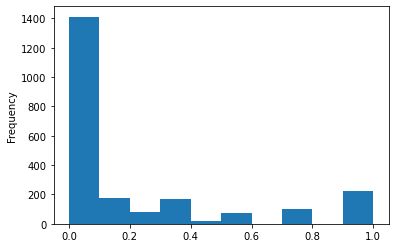

In [22]:
df['score'].plot(kind='hist')

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Для того, чтобы в соответствии с законом избавиться от изображений, которые содержат людей младше 16 лет требуется составить таблицу ключевых слов, по которым нужно будет отсеять не проходящие фотографии, которые косвенно или напрямую содержат упоминание детей

In [23]:
train = train[train['query_text'].str.contains('young|child|girl|little|children|boy|guy')==False]
train.head()

image                     query_id  \
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                         query_text  
22  A man sleeps under a blanket on a city street .  
23  A man sleeps under a blanket on a city street .  
24  A man sleeps under a blanket on a city street .  
25  A man sleeps under a blanket on a city street .  
26  A man sleeps under a blanket on a city street .

Далее объединим датавсет с оценками с отфильтрованным по закону датасетом и получим финальный

In [24]:
df = pd.merge(df, train, on=['image', 'query_id'])
df.head()

query_id                      image     score  \
0   434792818_56375e203f.jpg#2  1056338697_4f7d7ce270.jpg  0.000000   
1   256085101_2c2617c5d0.jpg#2  1084040636_97d9633581.jpg  0.333333   
2  3396157719_6807d52a81.jpg#2  1084040636_97d9633581.jpg  0.066667   
3  1425069308_488e5fcf9d.jpg#2  1096395242_fc69f0ae5a.jpg  0.066667   
4  2410320522_d967f0b75c.jpg#2  1107246521_d16a476380.jpg  0.133333   

                                          query_text  
0  A man and woman look back at the camera while ...  
1       Close-up of dog in profile with mouth open .  
2                       A dog gets on a trampoline .  
3  A white dog jumps to catch a blue ball in a li...  
4   Large dog plays with two smaller dogs on grass .

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [25]:
data_dir = pathlib.Path(path_image_train)
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

1000


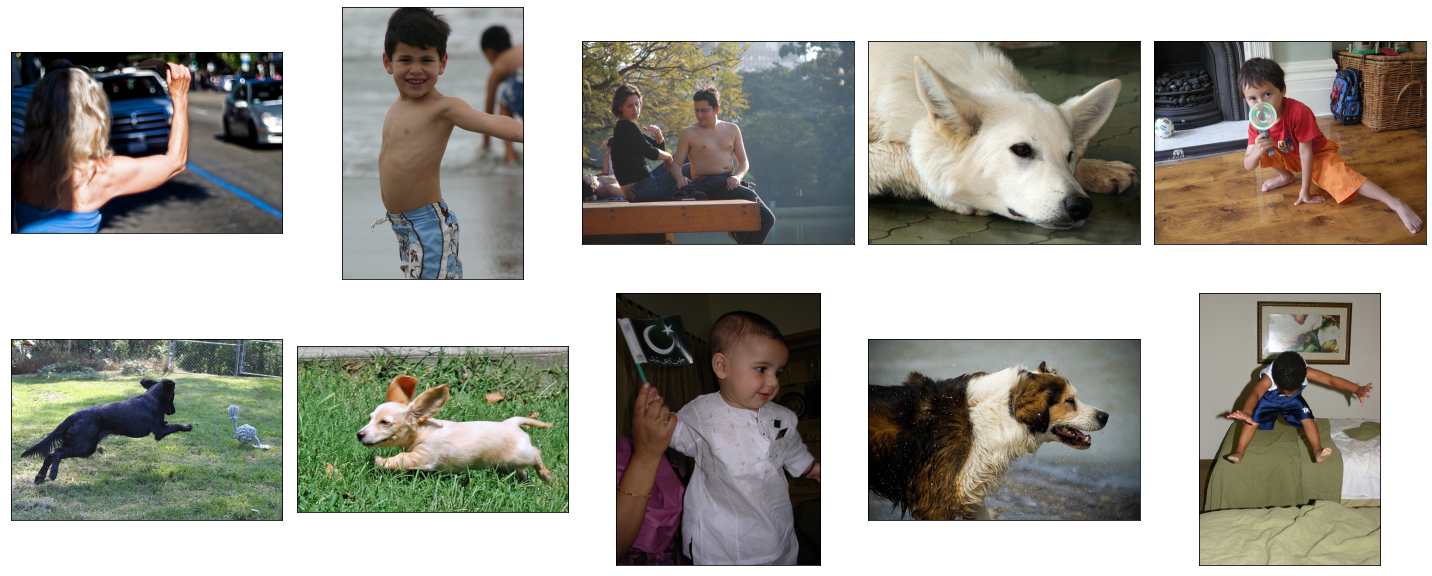

In [26]:
train_im = list(data_dir.glob('*.jpg'))
fig = plt.figure(figsize=(20,20))

for i in range(10):
    fig.add_subplot(5,5,i+1)
    plt.imshow(Image.open(str(train_im[i])))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [27]:
_IMAGE_NET_TARGET_SIZE = (224, 224)


class Img2Vec(object):

    def __init__(self):
        
        model = resnet50.ResNet50(weights='imagenet')
        layer_name = 'avg_pool'
        self.intermediate_layer_model = Model(inputs=model.input, 
                                              outputs=model.get_layer(layer_name).output)


    def get_vec(self, image_path):
        """ Gets a vector embedding from an image.
        :param image_path: path to image on filesystem
        :returns: numpy ndarray
        """

        img = image.load_img(image_path, target_size=_IMAGE_NET_TARGET_SIZE)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet50.preprocess_input(x)
        intermediate_output = self.intermediate_layer_model.predict(x)
        
        return intermediate_output[0]

In [28]:
img2vec = Img2Vec()
vect_list  = []

In [29]:
for im in train_im:
    vect_list.append(img2vec.get_vec(im))

In [30]:
vect_df = pd.DataFrame(vect_list)

In [31]:
image_path = []
for i in range(len(train_im)):
    image_path.append(str(train_im[i])[22:])

In [32]:
vect_df['image'] = image_path
vect_df.head()

0         1         2         3         4         5         6  \
0  0.086642  0.001172  0.000000  2.470206  0.017124  0.000000  0.323182   
1  0.141304  0.003005  0.028062  0.109320  0.210576  0.056171  0.043012   
2  0.031607  0.058342  0.157920  0.364854  0.343370  0.051523  0.220488   
3  0.233551  0.247994  0.252041  0.088462  0.066200  0.548717  0.014288   
4  0.384494  0.324686  0.000000  1.333907  1.128213  0.224945  0.051456   

          7         8         9  ...      2039      2040      2041      2042  \
0  0.742261  0.011976  3.807511  ...  0.487888  1.598633  0.436898  0.720544   
1  0.197619  0.137894  0.026487  ...  0.006399  0.331207  3.602327  0.147199   
2  1.456919  1.353665  1.025765  ...  0.000681  0.372702  1.328049  0.453072   
3  0.167596  0.028426  0.549047  ...  0.000000  0.697289  0.364982  0.064451   
4  0.334905  1.184994  1.441674  ...  0.019042  1.420987  0.122524  0.464968   

       2043      2044      2045      2046      2047                      image  
0  0.062267  0.545401  0.021594  1.074830  0.103507  1056338697_4f7d7ce270.jpg  
1  0.013191  0.106088  0.819475  0.118434  0.462929   106490881_5a2dd9b7bd.jpg  
2  0.021987  0.112330  0.928759  0.335345  0.186148  1082379191_ec1e53f996.jpg  
3  0.639179  1.785501  0.643821  0.055397  0.316298  1084040636_97d9633581.jpg  
4  0.000000  1.032495  0.377534  2.016289  0.771515  1096395242_fc69f0ae5a.jpg  

[5 rows x 2049 columns]

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Для векторизации текстов будет использован Tf Idf векторизатор, поскольку это наиболее простой но тем не менее подходящий для выполнения данной задачи метод векторизации текстов

In [33]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['query_text'])
tfidf_df = pd.DataFrame.sparse.from_spmatrix(X)

In [34]:
tfidf_df['query_text'] = df['query_text']
tfidf_df.head()

0    1    2    3    4    5    6    7    8    9  ...  992  993  994  995  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   996  997  998  999  1000                                         query_text  
0  0.0  0.0  0.0  0.0   0.0  A man and woman look back at the camera while ...  
1  0.0  0.0  0.0  0.0   0.0       Close-up of dog in profile with mouth open .  
2  0.0  0.0  0.0  0.0   0.0                       A dog gets on a trampoline .  
3  0.0  0.0  0.0  0.0   0.0  A white dog jumps to catch a blue ball in a li...  
4  0.0  0.0  0.0  0.0   0.0   Large dog plays with two smaller dogs on grass .  

[5 rows x 1002 columns]

По итогам выполнения получили векторы текстов с использованием Tf Idf

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [35]:
df = pd.merge(df, vect_df, on=['image'])
df = pd.merge(df, tfidf_df, on=['query_text'])
df.head()

query_id                      image  score  \
0  434792818_56375e203f.jpg#2  1056338697_4f7d7ce270.jpg    0.0   
1  434792818_56375e203f.jpg#2  1056338697_4f7d7ce270.jpg    0.0   
2  434792818_56375e203f.jpg#2  1056338697_4f7d7ce270.jpg    0.0   
3  434792818_56375e203f.jpg#2  1056338697_4f7d7ce270.jpg    0.0   
4  434792818_56375e203f.jpg#2  1056338697_4f7d7ce270.jpg    0.0   

                                          query_text       0_x       1_x  2_x  \
0  A man and woman look back at the camera while ...  0.086642  0.001172  0.0   
1  A man and woman look back at the camera while ...  0.086642  0.001172  0.0   
2  A man and woman look back at the camera while ...  0.086642  0.001172  0.0   
3  A man and woman look back at the camera while ...  0.086642  0.001172  0.0   
4  A man and woman look back at the camera while ...  0.086642  0.001172  0.0   

        3_x       4_x  5_x  ...  991_y  992_y  993_y  994_y  995_y  996_y  \
0  2.470206  0.017124  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
1  2.470206  0.017124  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2  2.470206  0.017124  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
3  2.470206  0.017124  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
4  2.470206  0.017124  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   

   997_y  998_y  999_y  1000_y  
0    0.0    0.0    0.0     0.0  
1    0.0    0.0    0.0     0.0  
2    0.0    0.0    0.0     0.0  
3    0.0    0.0    0.0     0.0  
4    0.0    0.0    0.0     0.0  

[5 rows x 3053 columns]

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

На данном шаге будет обучена модель ргерессионого леса решений и проверен результат ее работы с помощью MAE поскольку мы работаем с числами в диапазоне от 0 до 1, MSE будет не самой подходящей метрикой поскольку ошибка при возведении в квадрат будет становиться лишь меньше

In [36]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['score']), y=df['score'], groups=df['image']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

In [37]:
train_df = train_df.drop(['query_id', 'image', 'query_text'], axis=1)
test_df = test_df.drop(['query_id', 'image', 'query_text'], axis=1)

In [38]:
RF = RandomForestRegressor(max_depth=2, random_state=0)
RF.fit(train_df.drop(['score'], axis=1), train_df['score'])

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


RandomForestRegressor(max_depth=2, random_state=0)

In [39]:
RF.predict(train_df.drop(['score'], axis=1))

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


array([0.21318778, 0.21318778, 0.21318778, ..., 0.29161393, 0.24026223,
       0.23280846])

In [40]:
RF.predict(test_df.drop(['score'], axis=1))

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


array([0.2215621 , 0.2215621 , 0.2215621 , ..., 0.28634877, 0.28325977,
       0.25838847])

In [41]:
mean_absolute_error(train_df['score'], RF.predict(train_df.drop(['score'], axis=1)))

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.24658823290608176

In [42]:
mean_absolute_error(test_df['score'], RF.predict(test_df.drop(['score'], axis=1)))

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.25263485626520377

Во время выполнения данного этапа была обучена модель леса решений, которая показала неплохой результат по метрике MAE

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

Первым делом преобразуем изображения из папки с тестовыми изображениями в вектора.

In [43]:
data_dir = pathlib.Path(path_image_test)
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

100


In [44]:
test_im = list(data_dir.glob('*.jpg'))
test_vect_list = []
for im in test_im:
    test_vect_list.append(img2vec.get_vec(im))

In [45]:
vect_df = pd.DataFrame(test_vect_list)

In [46]:
image_path = []
for i in range(len(test_im)):
    image_path.append(str(test_im[i])[22:])

In [47]:
vect_df['image'] = image_path
vect_df.head()

0         1         2         3         4         5         6  \
0  0.272175  1.576390  0.027585  0.300476  0.416644  0.000000  0.148990   
1  0.276325  0.148964  0.024853  2.052887  0.213157  0.042238  0.206595   
2  0.386287  2.373862  0.000000  1.292067  0.027319  0.163298  0.075141   
3  0.218020  0.188730  0.464457  0.618098  0.083882  1.190597  0.000346   
4  0.159643  0.746572  0.083052  0.029215  0.654808  2.512208  0.000000   

          7         8         9  ...      2039      2040      2041      2042  \
0  0.042092  0.033999  1.145330  ...  0.013747  1.059039  1.459749  0.003923   
1  0.118905  1.047461  5.523541  ...  0.092874  0.507518  1.644324  0.017473   
2  0.820293  0.444818  0.118022  ...  0.130672  0.356571  0.102282  0.360560   
3  0.801636  0.000000  1.107858  ...  0.437987  0.795059  0.006109  1.226312   
4  0.244038  0.349723  0.638757  ...  0.034543  0.090714  0.327306  0.077639   

       2043      2044      2045      2046      2047                     image  
0  0.215762  0.000000  0.176677  0.010782  1.040679  177994172_10d143cb8d.jpg  
1  0.098960  0.211900  0.165620  0.100461  0.071168  232148178_4f45cc3284.jpg  
2  0.093413  0.225504  1.362394  0.537207  0.919195   23997871_6a9ca987b1.jpg  
3  0.789773  0.130585  0.314611  1.729886  0.166191  319634306_816f21677f.jpg  
4  0.000000  0.165572  0.021724  0.438811  0.075261  429546659_44cb09cbe2.jpg  

[5 rows x 2049 columns]

Далее извлечем несколько запросов в количестве 10 штук и преобразуем их текстовое описание в вектор

In [48]:
test_queries = pd.read_csv(path + 'test_queries.csv', sep='|', index_col=[0])
display(test_queries.shape)
test_queries.head()

(500, 3)

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [49]:
X = vectorizer.transform(test_queries['query_text'])

In [50]:
tfidf_test_df = pd.DataFrame.sparse.from_spmatrix(X)

In [51]:
tfidf_test_df['query_text'] = test_queries['query_text']
tfidf_test_df = tfidf_test_df.sample(n=10)
tfidf_test_df

0    1    2    3    4    5    6    7    8    9  ...  992  993  994  \
436  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
462  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
194  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
468  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
496  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
63   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
130  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
445  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
293  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     995  996  997  998  999  1000  \
436  0.0  0.0  0.0  0.0  0.0   0.0   
462  0.0  0.0  0.0  0.0  0.0   0.0   
194  0.0  0.0  0.0  0.0  0.0   0.0   
468  0.0  0.0  0.0  0.0  0.0   0.0   
88   0.0  0.0  0.0  0.0  0.0   0.0   
496  0.0  0.0  0.0  0.0  0.0   0.0   
63   0.0  0.0  0.0  0.0  0.0   0.0   
130  0.0  0.0  0.0  0.0  0.0   0.0   
445  0.0  0.0  0.0  0.0  0.0   0.0   
293  0.0  0.0  0.0  0.0  0.0   0.0   

                                            query_text  
436   A black dog jumps up to a man 's uplifted hand .  
462               A Yorkie trying to catch a red toy .  
194  The brown German shepherd dog is playing with ...  
468  Three people stand outside a fast food joint w...  
88             Two women on a movie set reviewing film  
496  A black dog has a dumbbell in his mouth lookin...  
63   A young boy throwing a rock into a pond in fro...  
130                              A crowd of children .  
445    A man and two boys standing in spraying water .  
293  Two Africans in red and blue shawls pose for a...  

[10 rows x 1002 columns]

Финальным шагом является составление для каждого запроса предсказаний совместно с каждым изображением и выбор результата, который наиболее близок к единице

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


"A black dog jumps up to a man 's uplifted hand ."

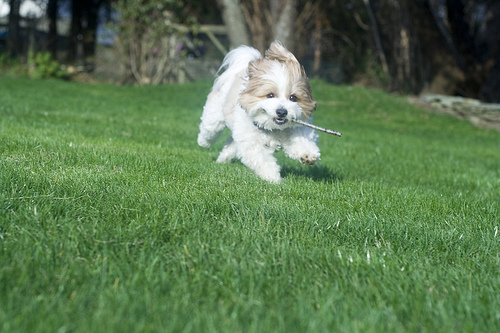

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


'A Yorkie trying to catch a red toy .'

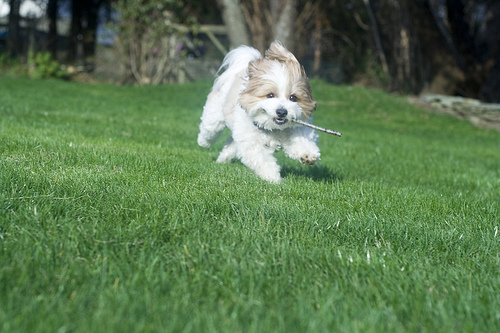

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


'The brown German shepherd dog is playing with a stick .'

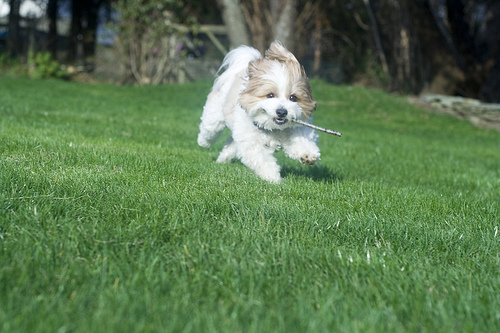

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


'Three people stand outside a fast food joint with their drinks .'

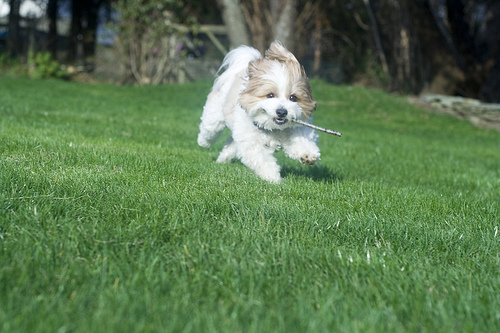

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


'Two women on a movie set reviewing film'

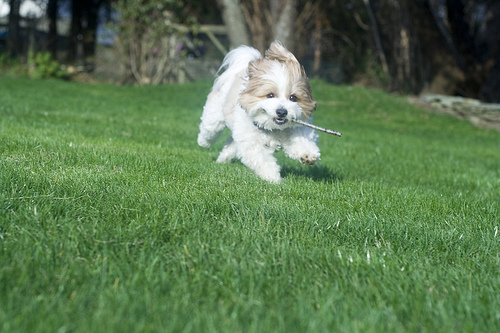

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


'A black dog has a dumbbell in his mouth looking at the person wearing blue .'

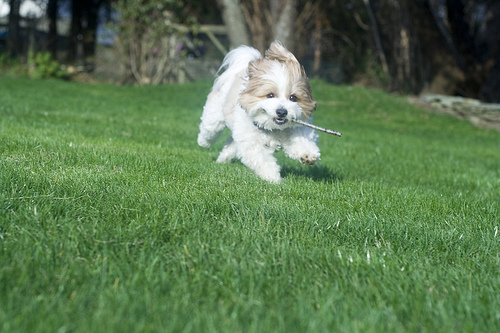

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


'A young boy throwing a rock into a pond in front of a large building .'

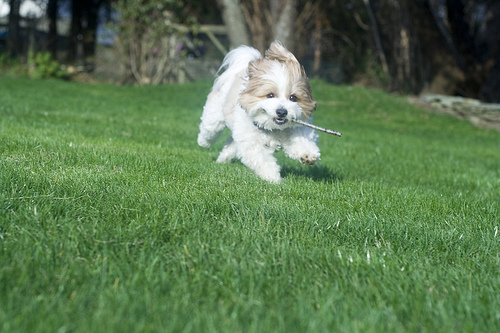

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


'A crowd of children .'

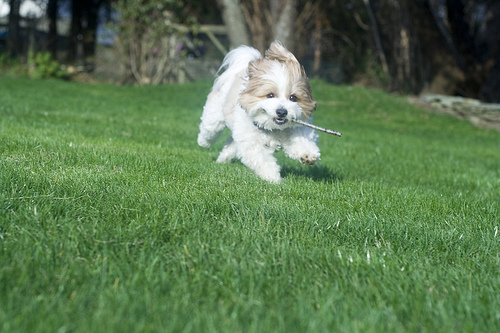

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


'A man and two boys standing in spraying water .'

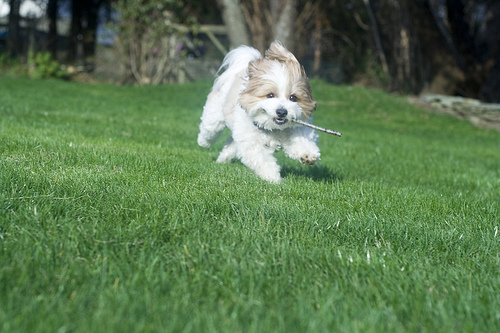

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


'Two Africans in red and blue shawls pose for a picture outside a barber shop .'

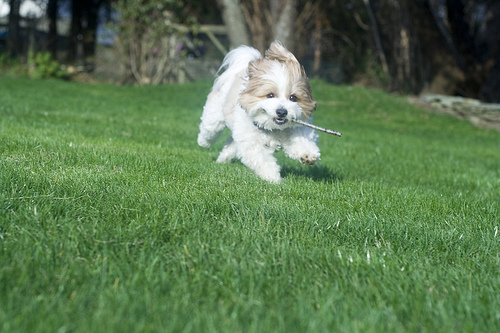

In [52]:
vect_df.drop('image', axis=1)

for i, row in tfidf_test_df.iterrows():
    vect_df['query_text'] = row['query_text']
    pred_df = pd.merge(vect_df, tfidf_test_df, on=['query_text'])
    pred_df = pred_df.drop(['image', 'query_text'], axis=1)

    preds = RF.predict(pred_df)
    index_max = np.argmax(preds)

    display(row['query_text'])
    display(Image.open(test_im[index_max]))
    

В моем решении получаем, что бегущая собачка идеально описывает все запросы:)

Если честно я немного запутался во время выполнения данного задания и не совсем понимаю что нужно сделать и обучать, как сопоставить полученный вектор изображения и вектор текста если у них абсолютно разные трансформеры которые никак нельзя сравнить, елинственное что можно сделать это обьединить результат двух векторизаций и попробовать на этом что то научить, но как видно из этого только собачка получается))

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска